# Simple example of using a linear regression-type ML algorithm
This notebook demonstrates how to use Julia for a simple calibration problem.
The data we use for the calibration comes from a number of single particles at different energies.

## Note for first-time users

The first time you run this code, you probably don't have any of the packages installed. In that case, the following cell will cause an error.
Just run the code that is suggested by the error message in a new cell, and try again. The first time after installing the package, you will see a "Precompiling..." message.
This step can take a while (especially for plotting packages) but is only necessary once after installing a new version of a package.

In [1]:
using Flux
using Statistics
using Base.Iterators: repeated, partition
using HDF5
using StatsPlots
using Random
using Printf

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278
┌ Info: Precompiling HDF5 [f67ccb44-e63f-5c2f-98bd-6dc0ccc4ba2f]
└ @ Base loading.jl:1278


In [2]:
function readData()
    # first, let's get rid of all the nans in the dataset
    # they complicate the training
    indata = zeros(Float64, (5, 10000*1400))
    c = h5open("/nfs/dust/ilc/user/jstrube/SiDCaloTraining/SiD_CaloCalibTraining_all_2calib.h5", "r") do file
        for (idx, ds) in enumerate(file)
            indata[:, 10000*(idx-1)+1:10000*(idx)] = ds[:,:]
        end
    end
    indata[:,(!isnan).(indata[2,:])]
end

readData (generic function with 1 method)

## Plotting the input data
The first step for us is to plot the raw input data before calibration. The data consists of four input columns and one label column.
The columns are 
1. The sum of all uncalibrated cell energies in the cluster
1. The x coordinate of the center of gravity of the cluster
1. y
1. z
1. The energy of the single particle that made the cluster

The data was created from LCIO files using `Calorimeter_calibration.jl`

In [3]:
function plotData(data, index, yvals)
    plot(
        histogram(data[index,yvals.==1], bins=30, label="1 GeV"),
        histogram(data[index,yvals.==2], bins=30, label="2 GeV"),
        histogram(data[index,yvals.==5], bins=30, label="5 GeV"),
        histogram(data[index,yvals.==10], bins=30, label="10 GeV"),
        histogram(data[index,yvals.==20], bins=30, label="20 GeV"),
        histogram(data[index,yvals.==50], bins=30, label="50 GeV"),
        histogram(data[index,yvals.==100], bins=30, label="100 GeV"),
        size=(1400,800)
    )
end

plotData (generic function with 1 method)

In [31]:
data = readData()
# Columns 1-4 are the input values
x = data[1:4, :]
# Column 5 contains the labels. Labels should be discrete values 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0
# We get rid of small floating point errors and make sure the labels are nice round numbers
y = round.(data[5, :])

# # Normalise the data in all dimensions except the energy measurement
x[4,:] ./= 250
x[3,:] ./= 500
x[2,:] .-= 1300
x[2,:] ./= 50;

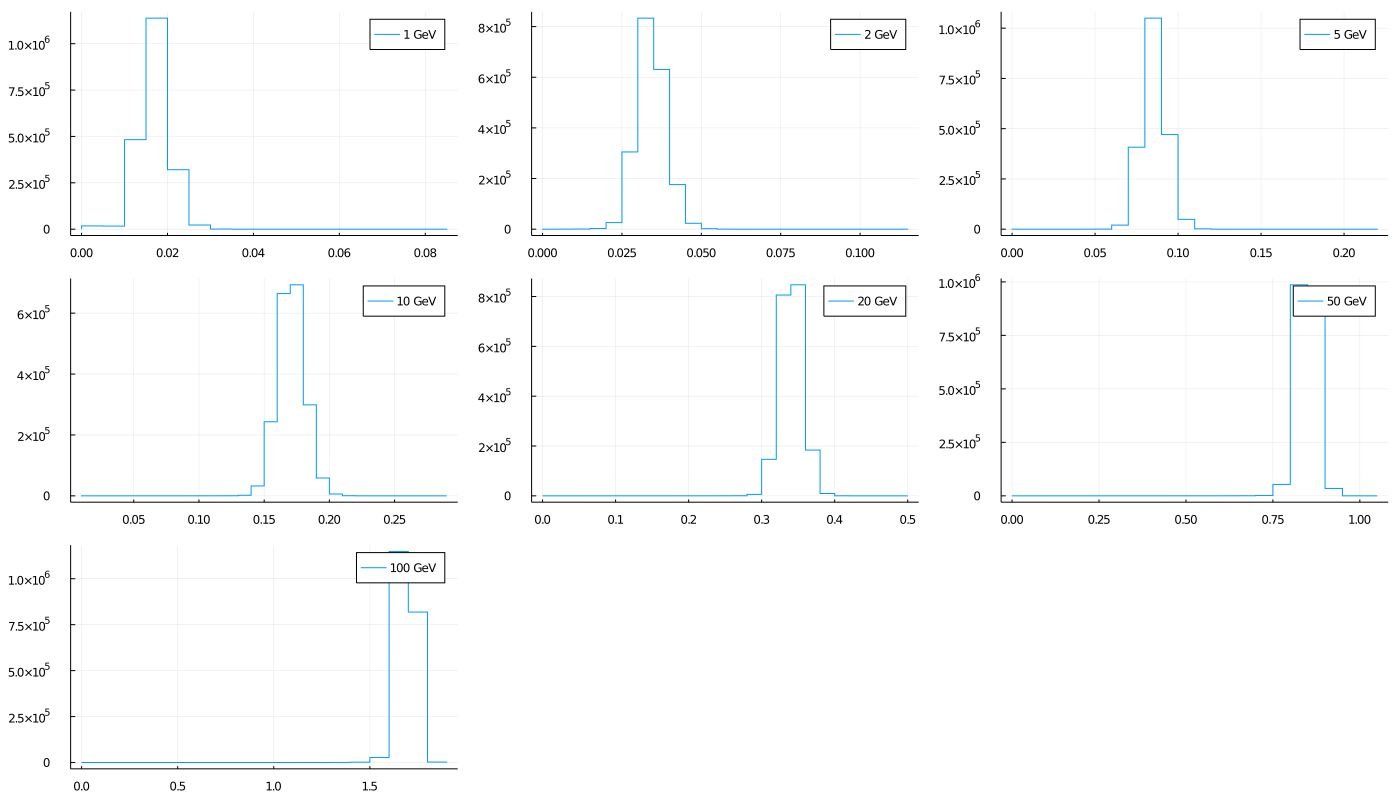

In [5]:
# uncalibrated cluster energy
plotData(x, 1, y) 

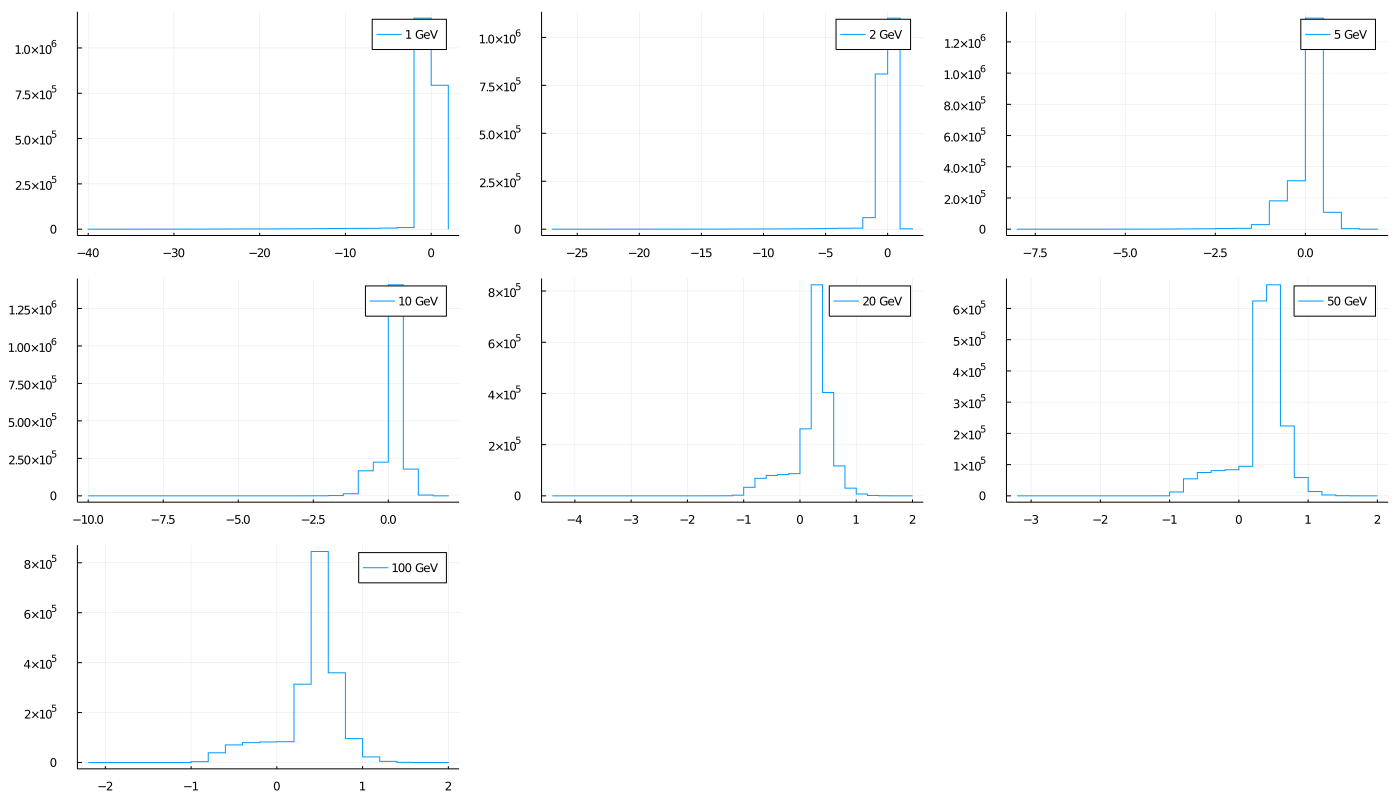

In [6]:
# x coordinate of the cluster
plotData(x, 2, y)

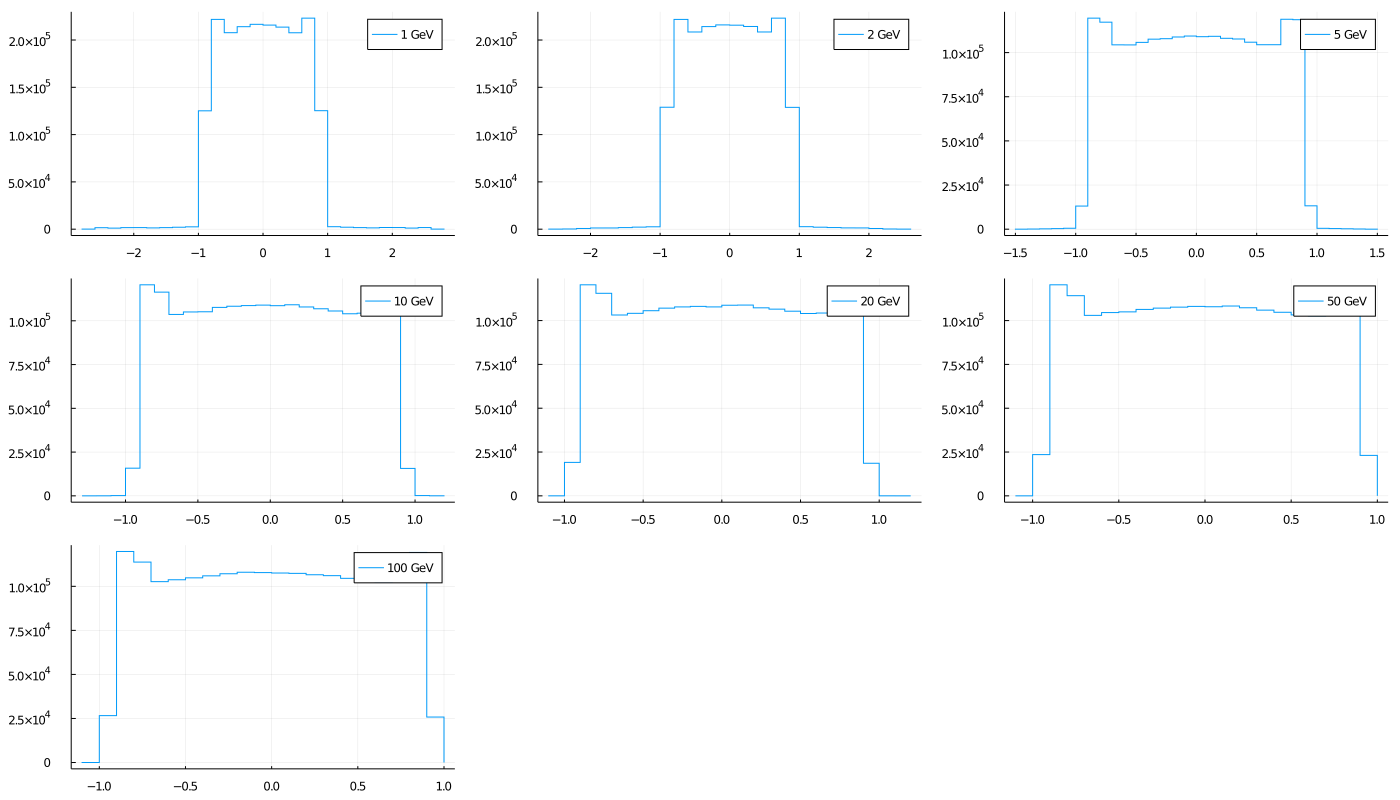

In [7]:
# y coordinate of the cluster
plotData(x, 3, y)

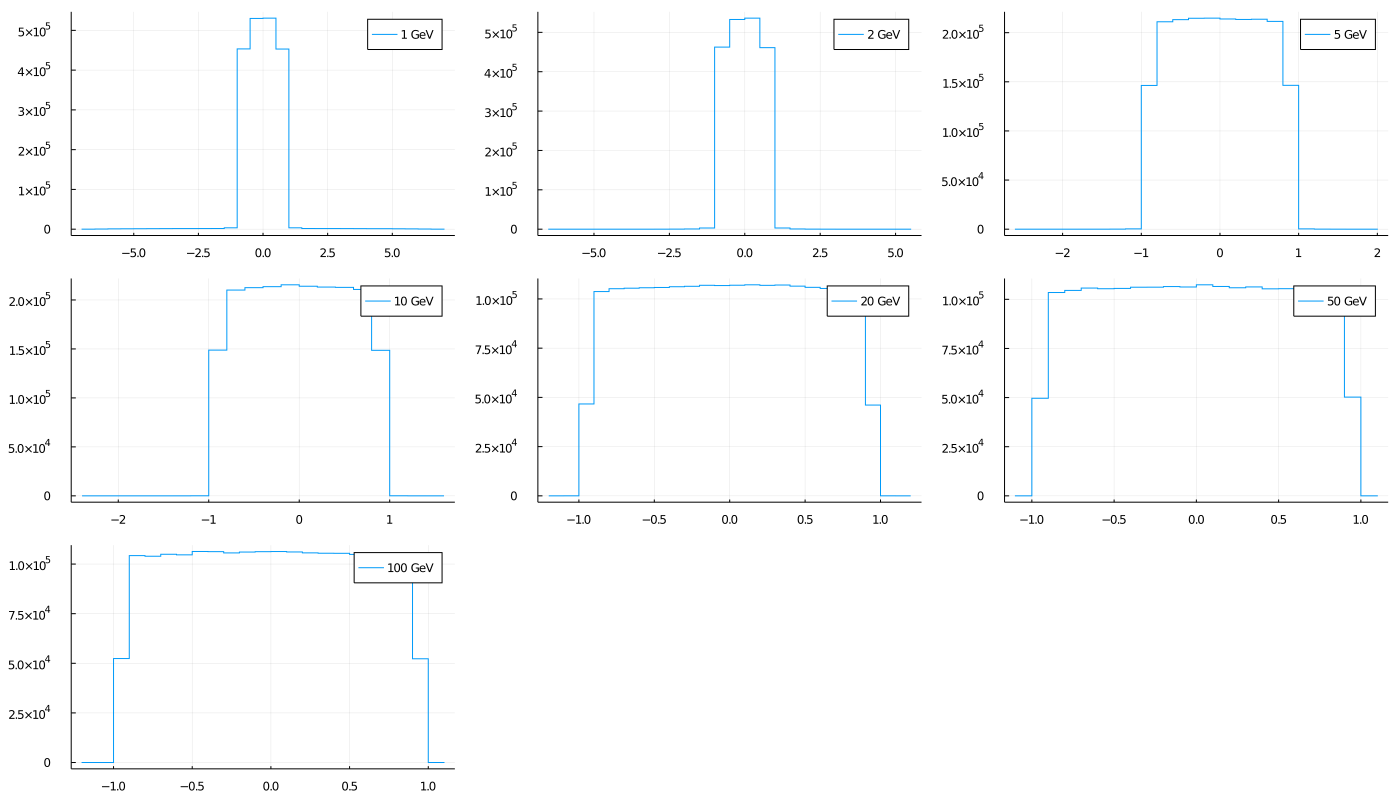

In [8]:
#z coordinate of the cluster
plotData(x, 4, y)

In [9]:
size(data)

(5, 13998644)

In [10]:
# this function makes one plot for each energy
function animateData(data, index, yvals)
    plot(
        histogram(data[index,yvals.==1], bins=-1:0.1:9, label="1 GeV", legend=:topright),
        histogram(data[index,yvals.==2], bins=-1:0.1:9, label="2 GeV", legend=:topright),
        histogram(data[index,yvals.==5], bins=-1:0.1:9, label="5 GeV", legend=:topleft),
        histogram(data[index,yvals.==10], bins=0:0.3:15, label="10 GeV", legend=:topleft),
        histogram(data[index,yvals.==20], bins=0:0.5:30, label="20 GeV", legend=:topleft),
        histogram(data[index,yvals.==50], bins=0:1.2:60, label="50 GeV", legend=:topleft),
        histogram(data[index,yvals.==100], bins=0:1.2:110, label="100 GeV", legend=:topleft),
        size=(1400,800)
    )
end

animateData (generic function with 1 method)

In [11]:
# this function plots all of the energies in the same frame
function animateDataInOne(data, index, yvals)
    histogram(data[index,yvals.==1], bins=0:0.5:110, label="1 GeV")
    histogram!(data[index,yvals.==2], bins=0:0.5:110, label="2 GeV")
    histogram!(data[index,yvals.==5], bins=0:0.5:110, label="5 GeV")
    histogram!(data[index,yvals.==10], bins=0:0.5:110, label="10 GeV")
    histogram!(data[index,yvals.==20], bins=0:0.5:110, label="20 GeV")
    histogram!(data[index,yvals.==50], bins=0:0.5:110, label="50 GeV")
    histogram!(data[index,yvals.==100], bins=0:0.5:110, label="100 GeV")
end

animateDataInOne (generic function with 1 method)

In [12]:
m = Chain(Dense(4,1; initW=Flux.glorot_normal, initb=Flux.glorot_normal),
# Dense(10, 1, celu),
)

Chain(Dense(4, 1))

In [13]:
# this loss is the mean square error of the prediction
loss(x, y) = Flux.mse(m(x), y)

loss (generic function with 1 method)

In [14]:
function distributionMeansErrors(x, y)
    twoGeV = m(x[:, y .== 2])
    fiveGeV = m(x[:, y .== 5])
    tenGeV = m(x[:, y .== 10])
    twentyGeV = m(x[:, y .== 20])
    fiftyGeV = m(x[:, y .== 50])
    hundredGeV = m(x[:, y .== 100])

    return [
        mean(twoGeV), mean(fiveGeV), mean(tenGeV),
        mean(twentyGeV), mean(fiftyGeV), mean(hundredGeV)
        ], [var(twoGeV), var(fiveGeV), var(tenGeV), var(twentyGeV), var(fiftyGeV), var(hundredGeV)]
end

distributionMeansErrors (generic function with 1 method)

In [15]:
# this loss is the mean square error for each of the classes
function loss2(x, y)
    trueVals = [2.0,5.0,10.0,20.0,50.0,100.0]
    sum((distributionMeansErrors(x, y)[1]-trueVals).^2)
end

loss2 (generic function with 1 method)

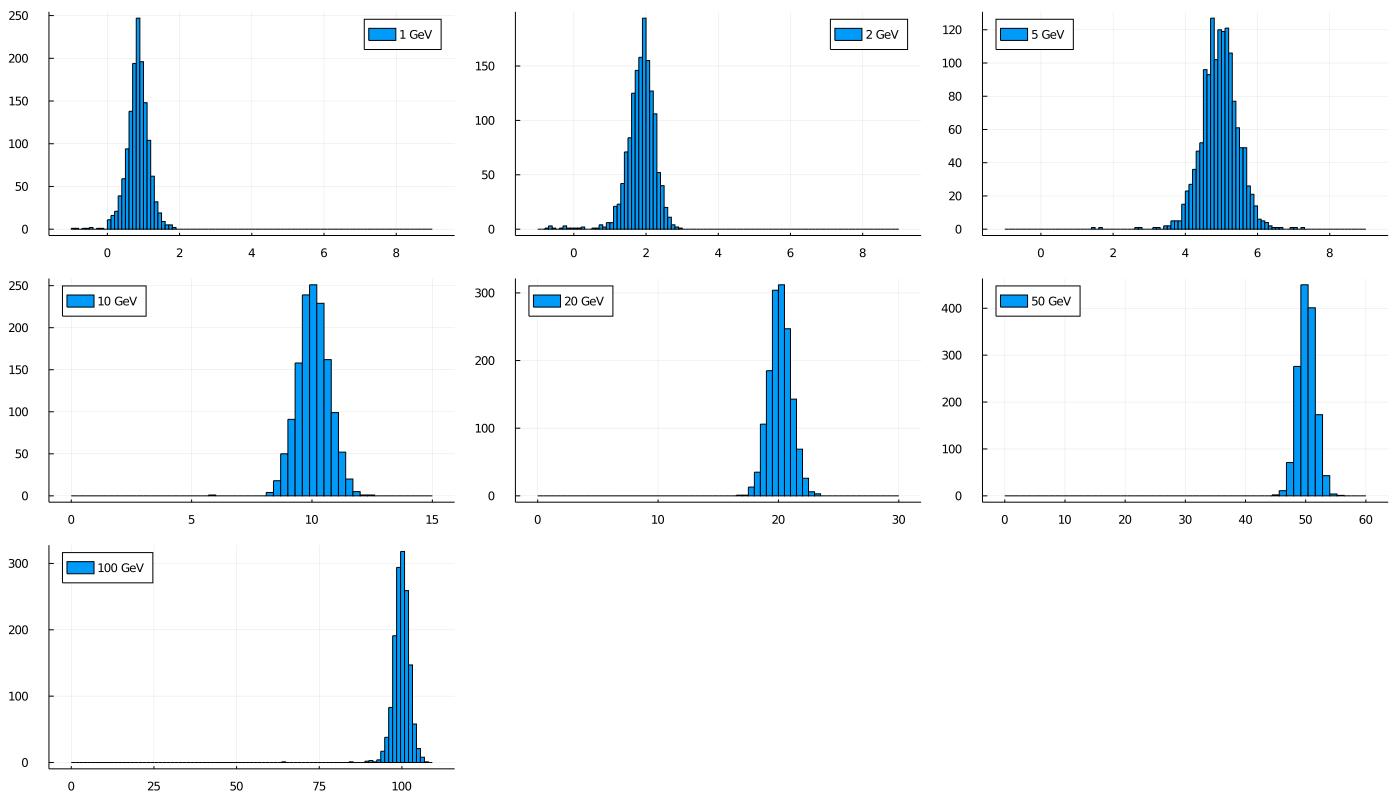

In [16]:
for epoch in 1:100
    indices = randperm(size(data, 2));
    trainData = x[:,indices[1:100000]]
    trainLabels = y[indices[1:100000]]
    testData = x[:,indices[100001:110000]]
    testLabels = y[indices[100001:110000]]
    dataset = Flux.Data.DataLoader(trainData, trainLabels, batchsize=100, shuffle=true)
    lr = 0.0001
    opt = Descent(lr)
    Flux.train!(loss2, params(m), dataset, opt)
#     @show(epoch, loss2(testData, testLabels))
    IJulia.clear_output(true)
    display(animateData(m(testData), 1, testLabels))
#     savefig(@sprintf "calibratedEnergy_epoch_%03d.pdf" epoch)
#     animateDataInOne(m(testData), 1, testLabels)
#     savefig(@sprintf "calibratedEnergyInOne_epoch_%03d.pdf" epoch)
end

In [52]:
using Distributions

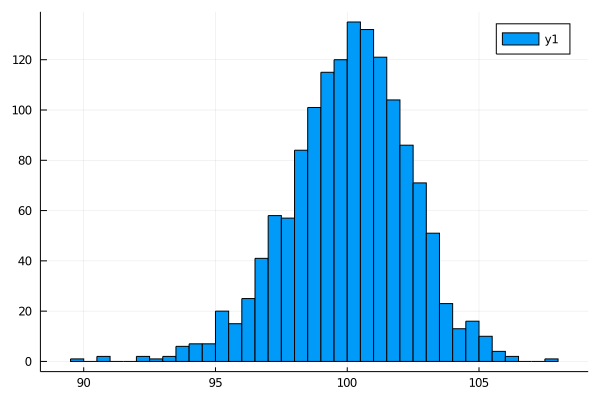

In [51]:
indices = randperm(size(data, 2))[1:10000]
onehundredGeV = y[indices] .== 100
x100 = x[:, indices[onehundredGeV]]
y100 = y[indices[onehundredGeV]]
data100 = (m(x100)[1,:])
